In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import DenseNet121
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100

In [4]:
directory_path = '/content/drive/MyDrive/PlantVillage'

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2154 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names

In [7]:
train_ds = dataset.take(int(0.8 * len(dataset)))
val_ds = dataset.skip(int(0.8 * len(dataset))).take(int(0.1 * len(dataset)))
test_ds = dataset.skip(int(0.8 * len(dataset))).skip(int(0.1 * len(dataset)))

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [11]:
train_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(
    lambda x, y: (resize_and_rescale(x), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(
    lambda x, y: (resize_and_rescale(x), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# Load pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze the base model
base_model.trainable = False

29084464/29084464 [==============================] - 2s 0us/step


In [13]:
# Create new model on top
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)


In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 3)                 3075      
                                                                 
Total params: 7040579 (26.86 MB)
Trainable params: 3075 (12.01 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [15]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

scores = model.evaluate(test_ds)

Epoch 1/100
54/54 [==============================] - 482s 283ms/step - loss: 0.7041 - accuracy: 0.6794 - val_loss: 0.4039 - val_accuracy: 0.8438
Epoch 2/100
54/54 [==============================] - 8s 141ms/step - loss: 0.3197 - accuracy: 0.9028 - val_loss: 0.2564 - val_accuracy: 0.9271
Epoch 3/100
54/54 [==============================] - 8s 145ms/step - loss: 0.2251 - accuracy: 0.9439 - val_loss: 0.1900 - val_accuracy: 0.9479
Epoch 4/100
54/54 [==============================] - 7s 128ms/step - loss: 0.1753 - accuracy: 0.9595 - val_loss: 0.1601 - val_accuracy: 0.9740
Epoch 5/100
54/54 [==============================] - 8s 140ms/step - loss: 0.1452 - accuracy: 0.9664 - val_loss: 0.1294 - val_accuracy: 0.9792
Epoch 6/100
54/54 [==============================] - 8s 143ms/step - loss: 0.1250 - accuracy: 0.9734 - val_loss: 0.1133 - val_accuracy: 0.9792
Epoch 7/100
54/54 [==============================] - 7s 133ms/step - loss: 0.1089 - accuracy: 0.9774 - val_loss: 0.1009 - val_accuracy: 0.97

In [16]:
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

Test Loss: 0.011796541512012482
Test Accuracy: 0.9921875


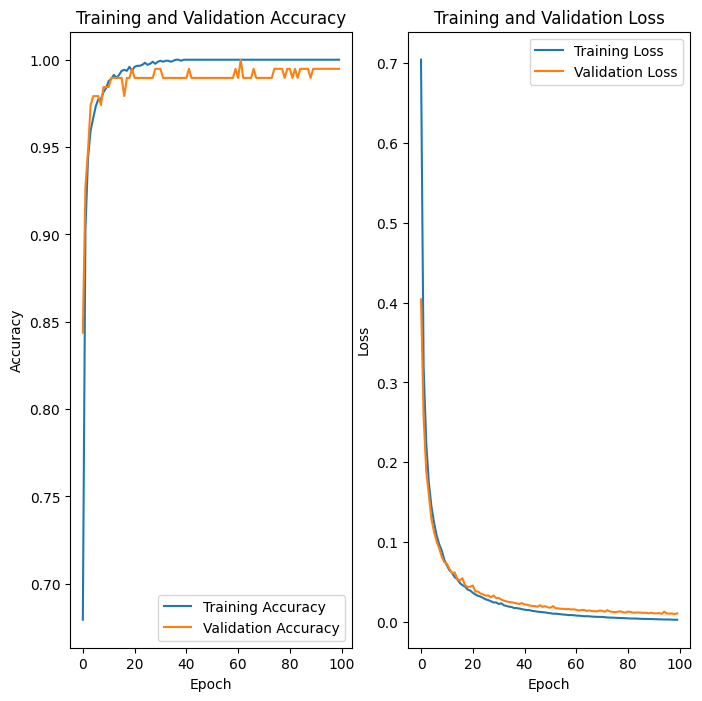

In [17]:
# Plot training history
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.save('/content/drive/MyDrive/MyFolder/myModeldense.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
